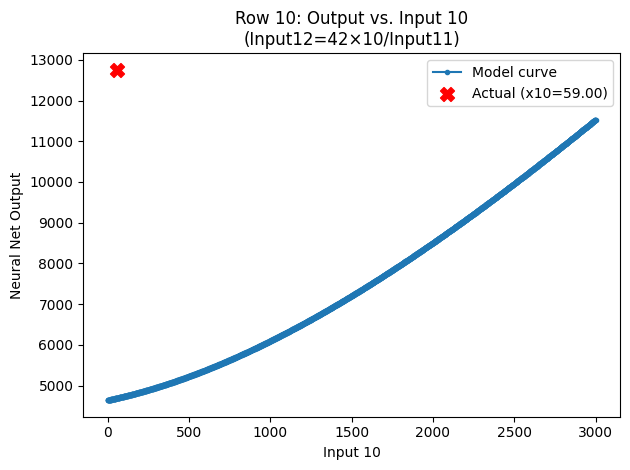

In [3]:
import pickle
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype

# --- 1) Paths and parameters ---
DATA_PATH     = '/home/kamiar/chevron/Acid-neural-net/arxiv/First data/data/test_cleaned.csv'                  # your CSV with a test row
#DATA_PATH     = '/home/kamiar/chevron/Acid-neural-net/data/training_validation.csv'
MODEL_PATH    = '/home/kamiar/chevron/Acid-neural-net/arxiv/First data/good_Models/trained_model_50c0e94e.pt'  # your saved model
SCALER_X_PATH = 'scaler_X.pkl'
SCALER_Y_PATH = 'scaler_y.pkl'
HIDDEN_DIMS   = [8, 4]    # must match training
ACTIVATION    = 'Softplus'
ROW_INDEX     = 10      # the row number 'i' you want to use

# --- 2) Load the test DataFrame and extract fixed inputs from row i ---
df = pd.read_csv(DATA_PATH)
row = df.iloc[ROW_INDEX]

# Build a dict of fixed inputs from that row, excluding 10 & 12
fixed_inputs = {}
for i in range(1, 19):
    name = f'Input {i}'
    if i not in (10, 12):
        fixed_inputs[name] = row[name]

# --- 3) Load scalers ---
with open(SCALER_X_PATH, 'rb') as f:
    scaler_X = pickle.load(f)
with open(SCALER_Y_PATH, 'rb') as f:
    scaler_y = pickle.load(f)

# --- 4) Categories for Inputs 1–8 ---
categories_map = {
    'Input 1': [1, 2],
    'Input 2': [1, 2, 3, 4, 5],
    'Input 3': [1, 2, 3, 4, 5],
    'Input 4': list(range(1, 18)),
    'Input 5': list(range(1, 6)),
    'Input 6': [1, 2, 3],
    'Input 7': [1, 2, 3, 4],
    'Input 8': list(range(1, 11)),
}

# --- 5) Rebuild & load the model ---
def build_model(input_dim, hidden_dims, activation='ReLU'):
    act_key = activation.strip().lower()
    layers = []
    in_dim = input_dim
    for h in hidden_dims:
        layers.append(nn.Linear(in_dim, h))
        if act_key not in ('linear', 'none'):
            layers.append(getattr(nn, activation)())
        in_dim = h
    layers.append(nn.Linear(in_dim, 1))
    return nn.Sequential(*layers)

# figure out the network input dimension
cat_dim = sum(len(v) for v in categories_map.values())
num_dim = scaler_X.scale_.shape[0]
input_dim = cat_dim + num_dim

model = build_model(input_dim, HIDDEN_DIMS, ACTIVATION)
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()

# --- 6) Feature‐vector constructor given x10 ---
def make_feature_vector(x10):
    # compute input12
    x11 = fixed_inputs['Input 11']
    x12 = 42.0 * x10 / x11

    # 1) one‐hot Inputs 1–8
    cat_parts = []
    for i in range(1, 9):
        name = f'Input {i}'
        cats = categories_map[name]
        val  = fixed_inputs[name]
        onehot = [1.0 if val == c else 0.0 for c in cats]
        cat_parts.extend(onehot)
    cat_arr = np.array(cat_parts, dtype=np.float32).reshape(1, -1)

    # 2) numeric Inputs 9–18
    num_vals = []
    for i in range(9, 19):
        nm = f'Input {i}'
        if i == 10:
            num_vals.append(x10)
        elif i == 12:
            num_vals.append(x12)
        else:
            num_vals.append(fixed_inputs[nm])
    num_arr = np.array(num_vals, dtype=np.float32).reshape(1, -1)

    # 3) normalize numeric (scaler_X.mean_/scale_ are float64, so this upcasts)
    num_scaled = (num_arr - scaler_X.mean_) / scaler_X.scale_
    num_scaled = num_scaled.astype(np.float32)   # **cast back to float32**

    # 4) concatenate and ensure float32
    X = np.hstack([cat_arr, num_scaled]).astype(np.float32)

    return X

# --- 7) Sweep Input 10 and predict ---
INPUT10_MIN, INPUT10_MAX = 0.0, 3000.0
NUM_POINTS = 2000
x10_vals = np.linspace(INPUT10_MIN, INPUT10_MAX, NUM_POINTS)
y_preds  = []

with torch.no_grad():
    for x10 in x10_vals:
        X_feat    = make_feature_vector(x10)
        pred_norm = model(torch.from_numpy(X_feat)).cpu().numpy().ravel()[0]
        pred_orig = scaler_y.inverse_transform([[pred_norm]]).ravel()[0]
        y_preds.append(pred_orig)

# --- 8) Plot the result ---
actual_x10 = row['Input 10']
actual_y   = row['Output 1']

plt.figure()
plt.plot(x10_vals, y_preds, '-o', markersize=3, label='Model curve')
plt.scatter(actual_x10, actual_y,
            color='red', marker='X', s=100,
            label=f'Actual (x10={actual_x10:.2f})')
plt.xlabel('Input 10')
plt.ylabel('Neural Net Output')
plt.title(f'Row {ROW_INDEX}: Output vs. Input 10\n(Input12=42×10/Input11)')
plt.legend()
plt.tight_layout()
plt.show()
